In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 1. Load the Datasets
train_df = pd.read_csv('../Data/train_lung_cancer.csv')
test_df = pd.read_csv('../Data/test_lung_cancer.csv')

# 2. Preprocessing Function (to ensure consistency)
def preprocess_data(df):
    df = df.copy()
    # Drop target if present (we separate it later)
    if 'LUNG_CANCER' in df.columns:
        y = df['LUNG_CANCER'].map({'YES': 1, 'NO': 0})
        X = df.drop(columns=['LUNG_CANCER'])
    else:
        y = None
        X = df
        
    # Convert Binary Columns (2 -> 1, 1 -> 0)
    # Note: We exclude AGE and GENDER from this specific replacement
    features_to_fix = [col for col in X.columns if col not in ['AGE', 'GENDER']]
    X[features_to_fix] = X[features_to_fix].replace({1: 0, 2: 1})
    
    # Encode Gender
    X['GENDER'] = X['GENDER'].map({'M': 0, 'F': 1})
    
    return X, y

# Apply Preprocessing
X_train, y_train = preprocess_data(train_df)
X_test, y_test = preprocess_data(test_df)

In [ ]:
import numpy as np
import pandas as pd



from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc
)

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns



In [3]:
# ============================
# Support Vector Machine (SVM)
# ============================

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# ---- Pipeline: Scaling INSIDE CV (Required by rubric) ---- #
svm_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC(probability=True, random_state=42))
])

# ---- Hyperparameter Grid ---- #
param_grid_svm = {
    "clf__kernel": ["linear", "rbf"],          # both common kernels
    "clf__C": [0.01, 0.1, 1, 10, 100],         # regularization strength
    "clf__gamma": ["scale", "auto"]           # only used for rbf
}

# ---- Stratified Cross-Validation ---- #
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ---- GridSearchCV ---- #
svm_grid = GridSearchCV(
    estimator=svm_pipe,
    param_grid=param_grid_svm,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1
)

# ---- Fit Model ---- #
svm_grid.fit(X_train, y_train)

# ---- Results ---- #
print("Best Hyperparameters:", svm_grid.best_params_)
print("Best Cross-Validated Accuracy:", svm_grid.best_score_)

Best Hyperparameters: {'clf__C': 100, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}
Best Cross-Validated Accuracy: 0.9029387755102041


In [4]:
best_model = svm_grid.best_estimator_

In [5]:
best_model.fit(X_train, y_train)

,steps,"[('scaler', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,C,100
,kernel,'rbf'
,degree,3
,gamma,'scale'


In [6]:
y_pred = best_model.predict(X_test)

# For ROC/AUC (need class probabilities)
try:
    y_proba = best_model.predict_proba(X_test)[:, 1]
except:
    # SVM without probability=True or some models
    y_proba = best_model.decision_function(X_test)

In [7]:
accuracy = accuracy_score(y_test, y_pred)
print("Test Set Accuracy:", accuracy)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Test Set Accuracy: 0.8870967741935484

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.75      0.63         8
           1       0.96      0.91      0.93        54

    accuracy                           0.89        62
   macro avg       0.75      0.83      0.78        62
weighted avg       0.91      0.89      0.89        62



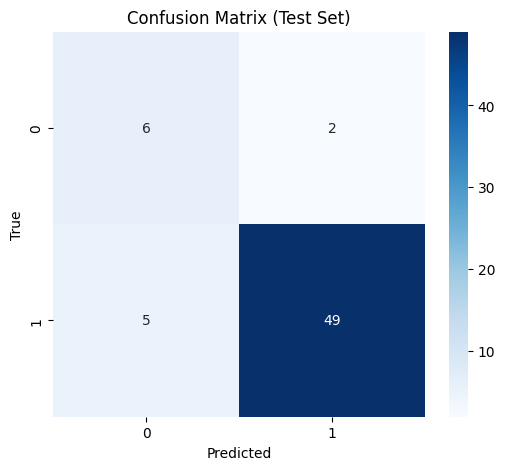

In [8]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

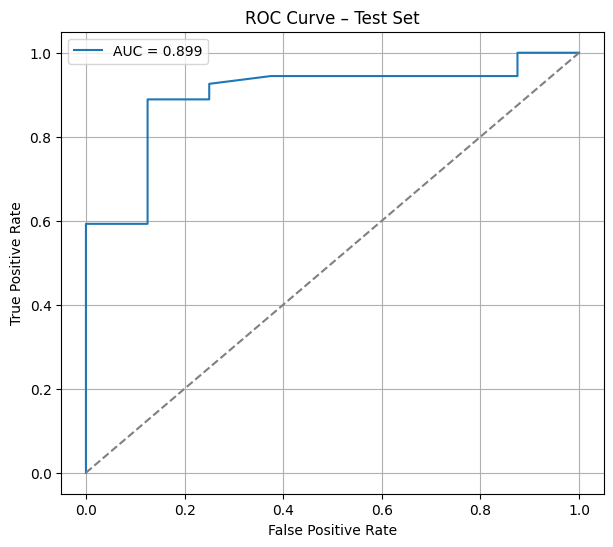

In [9]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], "--", color="gray")

plt.title("ROC Curve – Test Set")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()